In [1]:
!nvidia-smi

Fri May 22 15:15:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd drive/My\ Drive/Projects/TimeSeriesForecasting

/content/drive/My Drive/Projects/TimeSeriesForecasting


In [0]:
import os
import json
import pickle
import matplotlib
import numpy as np
import pandas as po
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [0]:
#from dtaidistance import dtw

In [6]:
import tensorflow as tf
from nbeats_model import NBeatsNet
import tensorflow.keras.backend as K

Using TensorFlow backend.


In [0]:
os.makedirs('model_checkpoints', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('Anomaly_Detection', exist_ok=True)

In [0]:
class weekday_args:
  def __init__(self):
    self.val_start = 12*24*150
    self.test_start = 12*24*200
    self.train_seq_len = 12*24*10
    self.val_seq_len = 12*24
    
    self.seasonality = 12*24
    self.batch_size = 256
    self.num_epochs = 100
    self.hidden_dim = 75
    self.theta_1 = 25
    self.theta_2 = 37
    self.nb_blocks_per_stack = 1
    
    self.upper_quantile = 0.99
    self.lower_quantile = 0.05

    self.save_folder = 'weekday_anomalies_upper_{}_lower_{}'.format(int(100*self.upper_quantile), int(100*self.lower_quantile))

In [0]:
args = weekday_args()

In [10]:
args.save_folder

'weekday_anomalies_upper_99_lower_5'

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [13]:
weekday_power_series = []
weekend_power_series = []
for i in tqdm(range(0, len(df)-7, 7*288)):
  weekday_power_series += df['W'][i:i+5*288].tolist()
  weekend_power_series += df['W'][i+5*288:i+7*288].tolist()
weekday_power_series = np.array(weekday_power_series)
weekend_power_series = np.array(weekend_power_series)

100%|██████████| 50/50 [00:00<00:00, 3129.56it/s]


In [0]:
os.makedirs('Anomaly_Detection/' + args.save_folder, exist_ok=True)

In [0]:
train_arr = weekday_power_series[: args.val_start]
val_arr = weekday_power_series[args.val_start: args.test_start]
test_arr = weekday_power_series[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data[i - train_seq_len: i].T.tolist())
        y.append(data[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [17]:
X_train, y_train = make_windows(train_arr)
X_val, y_val = make_windows(val_arr)
X_test, y_test = make_windows(test_arr)

100%|██████████| 11233/11233 [00:01<00:00, 7978.83it/s]


In [0]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [0]:
#sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4)
#loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [0]:
def pinball_loss(y_true, y_pred, tau):
    err = y_true - y_pred
    return K.mean(K.maximum(tau*err, (tau-1)*err), axis = -1)

In [0]:
loss_u = lambda y_true, y_pred : pinball_loss(y_true, y_pred, args.upper_quantile)
loss_l = lambda y_true, y_pred : pinball_loss(y_true, y_pred, args.lower_quantile)

In [22]:
model_u = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model_u.compile_model(loss=loss_u, learning_rate = 1e-3)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 2880, 1)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2880)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 75)           216075      lambda_1[0][0]                   
__________________________________________________________________________________________________
0/0/generic/d2 (Dense)          (None, 75)           5700        0/0/generic/d1[0][0]             
____________________________________________________________________________________________

In [23]:
history_u = model_u.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Train on 40033 samples, validate on 11233 samples
Epoch 1/100
40033/40033 [==============================] - 2s 51us/step - loss: 0.0237 - val_loss: 0.0045
Epoch 2/100
40033/40033 [==============================] - 2s 39us/step - loss: 0.0037 - val_loss: 0.0045
Epoch 3/100
40033/40033 [==============================] - 2s 40us/step - loss: 0.0031 - val_loss: 0.0041
Epoch 4/100
40033/40033 [==============================] - 2s 39us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 5/100
40033/40033 [==============================] - 2s 40us/step - loss: 0.0024 - val_loss: 0.0036
Epoch 6/100
40033/40033 [==============================] - 2s 39us/step - loss: 0.0022 - val_loss: 0.0036
Epoch 7/100
40033/40033 [==============================] - 2s 39us/step - loss: 0.0021 - val_loss: 0.0034
Epoch 8/100
40033/40033 [==============================] - 2s 41us/step - loss: 0.0020 - val_loss: 0.0040
Epoch 9/100
40033/40033 [==============================] - 2s 39us/step - loss: 0.0019 - val_loss: 0.0

In [24]:
best_epoch = np.argmin(np.array(history_u.history['val_loss']))+1
model_u.save_weights('Anomaly_Detection/' + args.save_folder + '/model_upper_{:02d}.h5'.format(best_epoch))
model_u.load_weights('Anomaly_Detection/' + args.save_folder + '/model_upper_{:02d}.h5'.format(best_epoch))
best_epoch

12

In [0]:
y_pred_u = model_u.predict(X_test)

In [26]:
model_l = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model_l.compile_model(loss=loss_l, learning_rate = 1e-3)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 2880, 1)      0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2880)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 75)           216075      lambda_2[0][0]                   
__________________________________________________________________________________________________
0/0/generic/d2 (Dense)          (None, 75)           5700        0/0/generic/d1[0][0]             
____________________________________________________________________________________________

In [27]:
history_l = model_l.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Train on 40033 samples, validate on 11233 samples
Epoch 1/100
40033/40033 [==============================] - 2s 45us/step - loss: 0.0096 - val_loss: 0.0069
Epoch 2/100
40033/40033 [==============================] - 2s 38us/step - loss: 0.0078 - val_loss: 0.0068
Epoch 3/100
40033/40033 [==============================] - 2s 41us/step - loss: 0.0072 - val_loss: 0.0071
Epoch 4/100
40033/40033 [==============================] - 2s 42us/step - loss: 0.0066 - val_loss: 0.0067
Epoch 5/100
40033/40033 [==============================] - 2s 42us/step - loss: 0.0064 - val_loss: 0.0074
Epoch 6/100
40033/40033 [==============================] - 2s 39us/step - loss: 0.0063 - val_loss: 0.0071
Epoch 7/100
40033/40033 [==============================] - 2s 38us/step - loss: 0.0059 - val_loss: 0.0073
Epoch 8/100
40033/40033 [==============================] - 2s 38us/step - loss: 0.0057 - val_loss: 0.0081


In [28]:
best_epoch = np.argmin(np.array(history_l.history['val_loss']))+1
model_l.save_weights('Anomaly_Detection/' + args.save_folder + '/model_lower_{:02d}.h5'.format(best_epoch))
model_l.load_weights('Anomaly_Detection/' + args.save_folder + '/model_lower_{:02d}.h5'.format(best_epoch))
best_epoch

4

In [0]:
y_pred_l = model_l.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f4d3ac9ef98> has a label of '_Quantile' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f4d3ac71a20> has a label of '_Quantile' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.


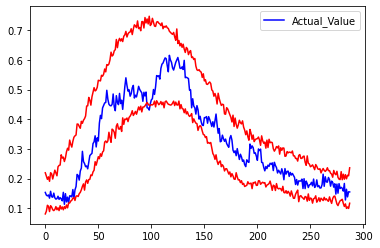

In [30]:
plt.plot(y_test[0], color = 'blue')
plt.plot(y_pred_u[0], color = 'red')
plt.plot(y_pred_l[0], color = 'red')
plt.legend(['Actual_Value', '_Quantile'.format(args.upper_quantile), '_Quantile'.format(args.lower_quantile)])

In [31]:
forecasts_l = []
forecasts_u = []
actuals = []
for i in tqdm(range(y_pred_u.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts_u += (scaler.inverse_transform(y_pred_u[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  forecasts_l += (scaler.inverse_transform(y_pred_l[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()

100%|██████████| 39/39 [00:00<00:00, 4526.23it/s]


In [0]:
u = np.array([f_u - a for f_u, a in zip(forecasts_u, actuals)])
u_t = np.where(u < 0, actuals, None)
u_picp = np.where(u < 0, 0, 1)

In [0]:
l = np.array([a - f_l for a, f_l in zip(actuals, forecasts_l)])
l_t = np.where(l < 0, actuals, None)
l_picp = np.where(l < 0, 0, 1)

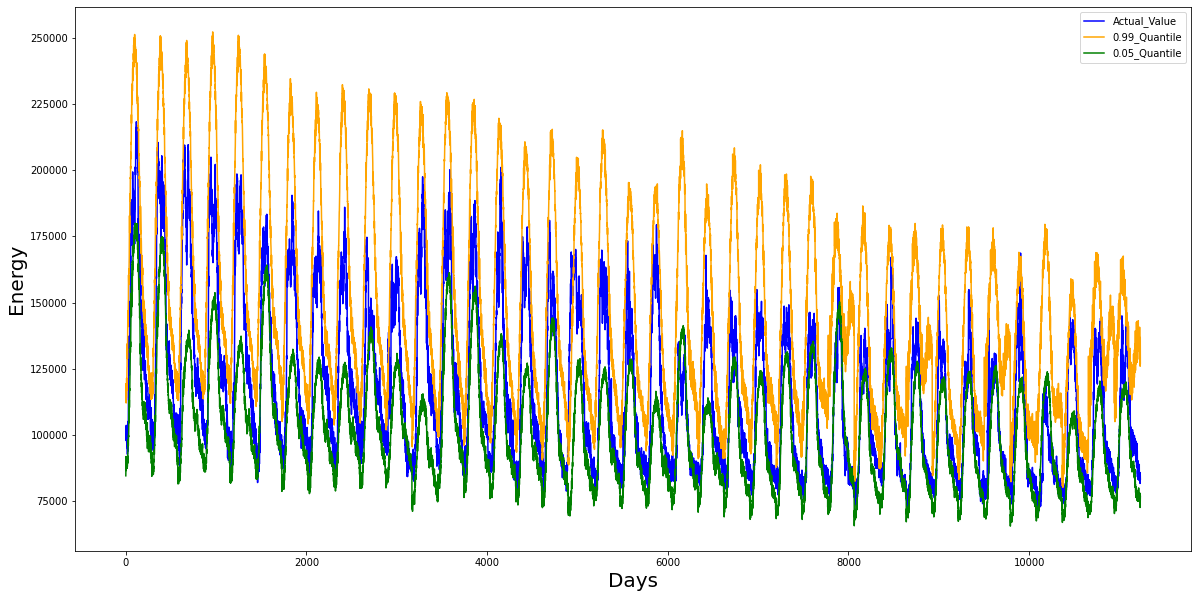

In [34]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy', size = 20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'blue')
plt.plot(forecasts_u, color = 'orange')
plt.plot(forecasts_l, color = 'green')
plt.legend(['Actual_Value', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/quantiles_weekday_{}_{}.png'.format(args.upper_quantile, args.lower_quantile))

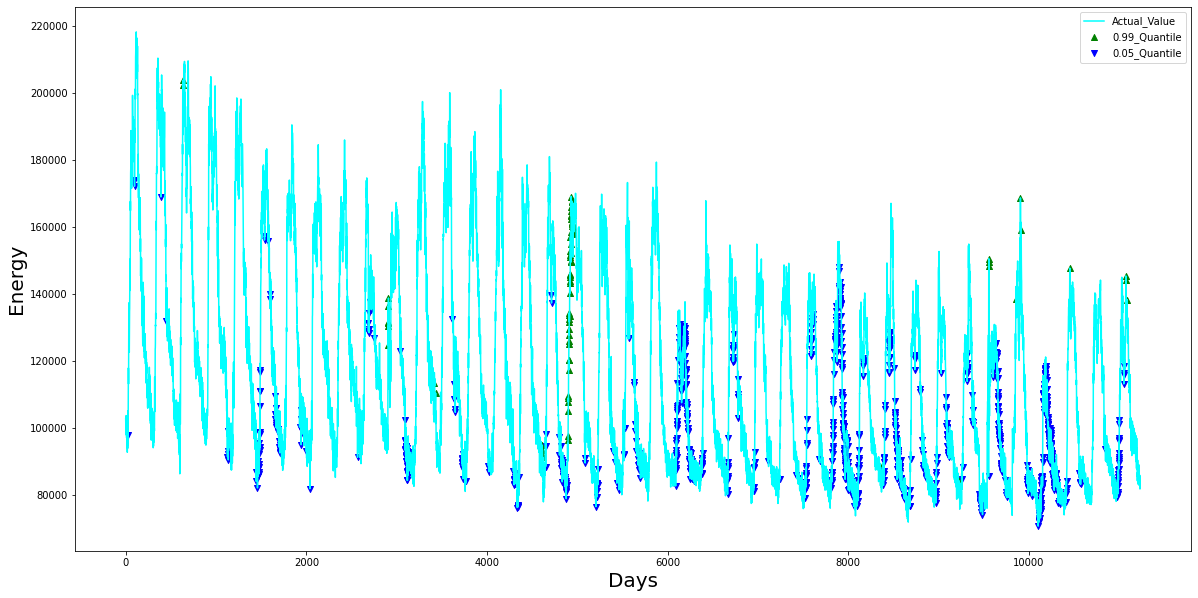

In [35]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy', size = 20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'cyan')
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['Actual_Value', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_actuals_weekday_{}_{}.png'.format(args.upper_quantile, args.lower_quantile))

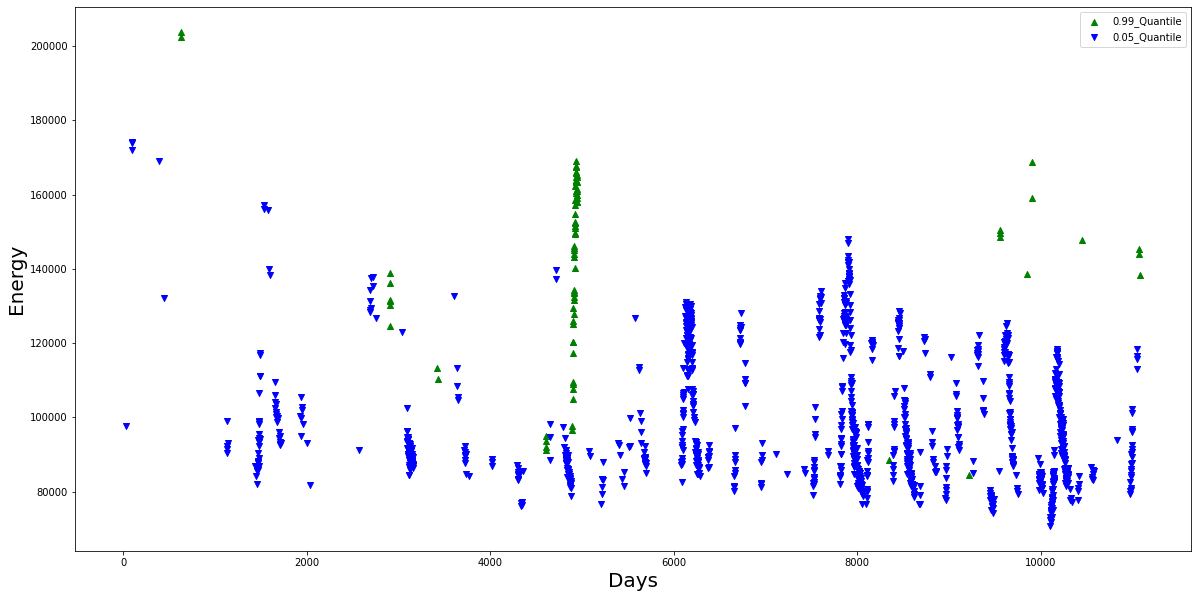

In [36]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy', size = 20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_weekday_{}_{}.png'.format(args.upper_quantile, args.lower_quantile))

In [0]:
if not os.path.exists('Anomaly_Detection/picp_pinaw.csv'):
  results = po.DataFrame(columns = ['model', 'upper_quantile', 'lower_quantile', 'PICP', 'PINAW'])  
else:
  results = po.read_csv('Anomaly_Detection/picp_pinaw.csv')

In [38]:
PICP = (np.sum(l_picp) + np.sum(u_picp))/(len(l_picp) + len(u_picp))
PICP

0.9440883190883191

In [0]:
E = np.array(actuals).max() - np.array(actuals).min()
N = len(actuals)

In [0]:
u_l = np.array([f_u - f_l for f_u, f_l in zip(forecasts_u, forecasts_l)])

In [41]:
PINAW = np.sum(u_l)/(N*E)
PINAW

0.31230746274535875

In [0]:
errors = {'model': 'NBEATS',
          'upper_quantile': args.upper_quantile,
          'lower_quantile': args.lower_quantile,
          'PICP': PICP,
          'PINAW': PINAW,      
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [43]:
results

,model,upper_quantile,lower_quantile,PICP,PINAW
0,z_score,0.95,0.05,0.968038,NaN
1,NBEATS,0.95,0.05,0.937322,0.280960
2,NBEATS,0.95,0.01,0.973558,0.354860
3,NBEATS,0.96,0.01,0.987046,0.360055
4,NBEATS,0.97,0.01,0.981838,0.354971
5,NBEATS,0.98,0.01,0.985354,0.373293
6,NBEATS,0.99,0.01,0.994391,0.468314
7,NBEATS,0.95,0.02,0.967236,0.287422
8,NBEATS,0.96,0.02,0.985800,0.368712
9,NBEATS,0.97,0.02,0.964699,0.309047


In [0]:
results.to_csv('Anomaly_Detection/picp_pinaw.csv', index=False)

In [0]:
z_scores = stats.zscore(np.array(actuals))

In [0]:
z_u = np.where(z_scores > 3, actuals, None)
z_l = np.where(z_scores < -3, actuals, None)

In [0]:
z_u_picp = np.where(z_scores > 3, 0, 1)
z_l_picp = np.where(z_scores < -3, 0, 1)

In [48]:
z_PICP = (np.sum(z_u_picp) + np.sum(z_l_picp))/(len(z_u_picp) + len(z_l_picp))
z_PICP

0.9989761396011396

In [49]:
'''
errors = {'model': 'z_score',
          'upper_quantile': args.upper_quantile,
          'lower_quantile': args.lower_quantile,
          'PICP': PICP,     
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)
results
results.to_csv('Anomaly_Detection/picp_pinaw.csv', index=False)
'''

"\nerrors = {'model': 'z_score',\n          'upper_quantile': args.upper_quantile,\n          'lower_quantile': args.lower_quantile,\n          'PICP': PICP,     \n          }\nerrors = po.Series(errors)\nresults = results.append(errors, ignore_index=True)\nresults\nresults.to_csv('Anomaly_Detection/picp_pinaw.csv', index=False)\n"

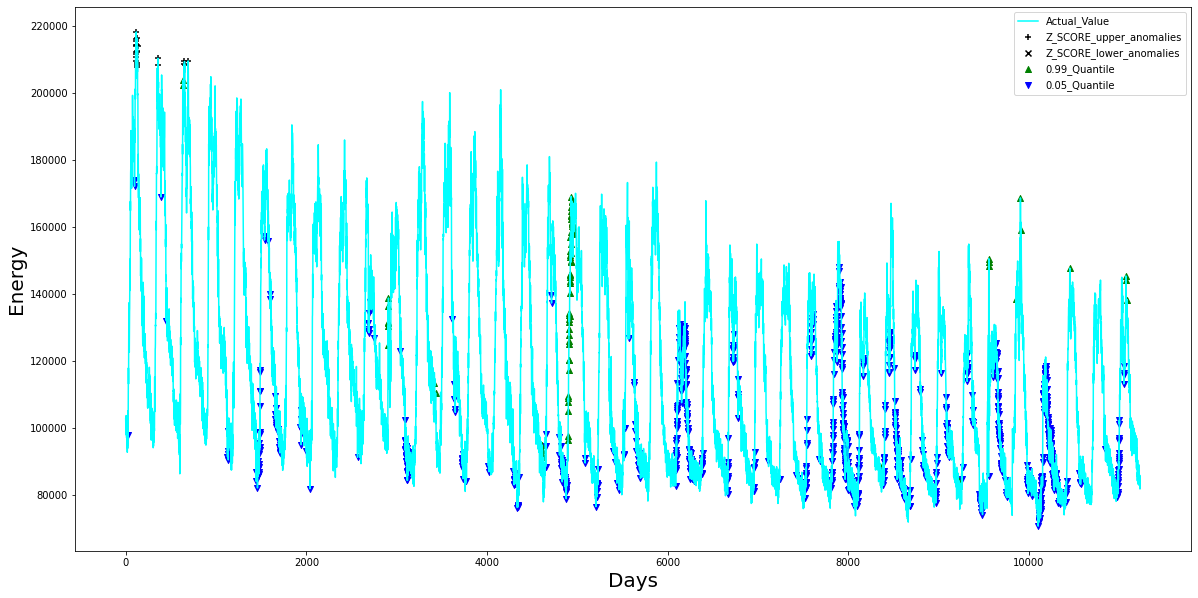

In [50]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy', size = 20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'cyan')
plt.scatter(range(len(z_u)), z_u, color = 'black', marker = '+')
plt.scatter(range(len(z_l)), z_l, color = 'black', marker = 'x')
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['Actual_Value', 'Z_SCORE_upper_anomalies', 'Z_SCORE_lower_anomalies', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_actuals_weekday_interval_vs_zscore.png')

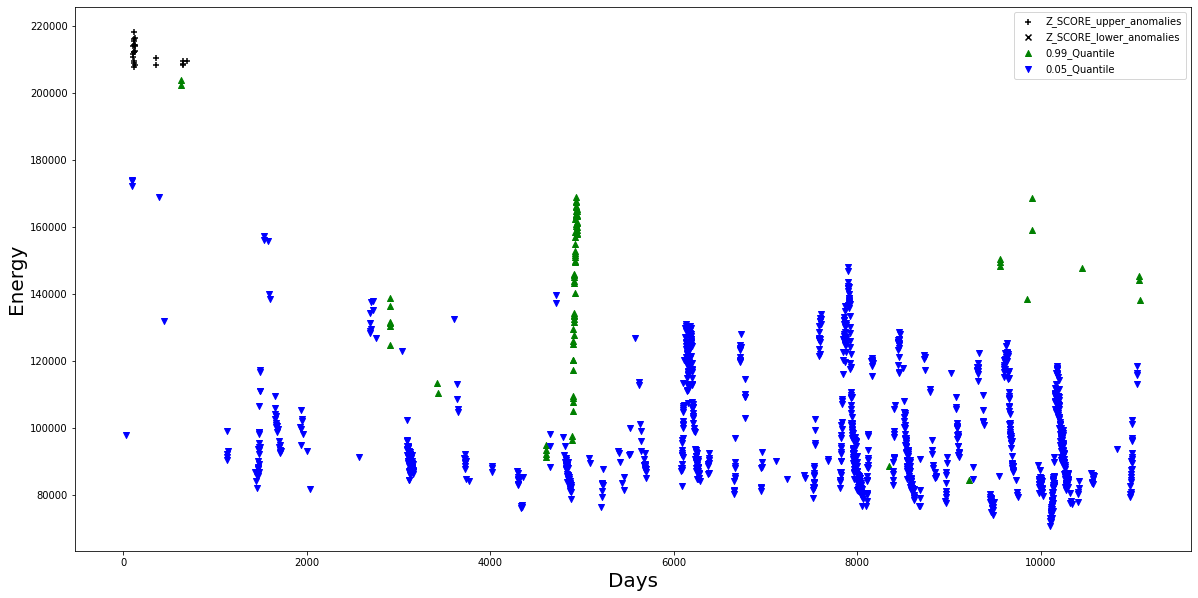

In [51]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy', size = 20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.scatter(range(len(z_u)), z_u, color = 'black', marker = '+')
plt.scatter(range(len(z_l)), z_l, color = 'black', marker = 'x')
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['Z_SCORE_upper_anomalies', 'Z_SCORE_lower_anomalies', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_weekday_interval_vs_zscore.png')

In [0]:
with open('Anomaly_Detection/' + args.save_folder + '/forecasts_u.pkl', 'wb') as f:
  pickle.dump(forecasts_u, f)

In [0]:
with open('Anomaly_Detection/' + args.save_folder + '/forecasts_l.pkl', 'wb') as f:
  pickle.dump(forecasts_l, f)

In [0]:
with open('Anomaly_Detection/' + args.save_folder + '/actuals.pkl', 'wb') as f:
  pickle.dump(actuals, f)

In [55]:
results

,model,upper_quantile,lower_quantile,PICP,PINAW
0,z_score,0.95,0.05,0.968038,NaN
1,NBEATS,0.95,0.05,0.937322,0.280960
2,NBEATS,0.95,0.01,0.973558,0.354860
3,NBEATS,0.96,0.01,0.987046,0.360055
4,NBEATS,0.97,0.01,0.981838,0.354971
5,NBEATS,0.98,0.01,0.985354,0.373293
6,NBEATS,0.99,0.01,0.994391,0.468314
7,NBEATS,0.95,0.02,0.967236,0.287422
8,NBEATS,0.96,0.02,0.985800,0.368712
9,NBEATS,0.97,0.02,0.964699,0.309047
